In [ ]:
import pandas as pd
import seaborn  as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
df = pd.read_csv("analytics_test.csv")

In [ ]:
events_per_query = df.groupby('query_id')['event'].count()
print(events_per_query.value_counts())


event
1    16927
2     1436
3       67
Name: count, dtype: int64


## Анализ пользовательского поведения

поскольку данные не позволяют точно выделить сессии (85% query_id содержат только 1 событие), оценим активность через:

1. Базовые метрики взаимодействия
2. Поведение пользователей (если доступен user_id)
3. CTR и позиции кликов как объективные показатели

In [ ]:
print("Распределение событий на query_id:")
print(df.groupby('query_id')['event'].count().value_counts())

metrics = {
    'Всего событий search': (df['event'] == 'search').sum(),
    'Всего событий view': (df['event'] == 'view').sum(),
    'CTR (tap/search)': (df['event'] == 'tap').sum() / (df['event'] == 'search').sum(),
    'Средняя позиция клика': df[df['event'] == 'tap']['click_position'].mean(),
    'Доля кликов в топ-3': (df[df['click_position'] <= 3]['event'] == 'tap').mean()
}

pd.DataFrame.from_dict(metrics, orient='index').rename(columns={0: 'Значение'})

Распределение событий на query_id:
event
1    16927
2     1436
3       67
Name: count, dtype: int64


,Значение
Всего событий search,4958.000000
Всего событий view,2917.000000
CTR (tap/search),1.323921
Средняя позиция клика,8.798903
Доля кликов в топ-3,0.196039


## Интерпретация результатов

### 1. Структура данных
- **85% запросов** (16,927) содержат только 1 событие
- **15% запросов** (1,503) имеют 2+ событий  
➔ Данные не позволяют анализировать полноценные пользовательские сессии

### 2. Основные метрики поиска
| Метрика | Значение | Проблема |
|---------|----------|----------|
| CTR | 132% | Некорректное значение (>100%) |
| Средняя позиция клика | 8.8 | Слишком глубокий скроллинг |
| Доля кликов в топ-3 | 19.6% | Крайне низкое качество первых позиций |

**Ключевые проблемы:**
- Аномальный CTR указывает на:
  - Возможное дублирование событий
  - Ошибки в разметке данных
- Только 1 из 5 кликов приходится на первые 3 позиции

### 3. Соотношение активностей
- **4,958** поисковых запросов
- **2,917** просмотров  
➔ 40% поисков не приводят к просмотру контента


In [ ]:
df.head()

,Unnamed: 0,user_id,sex,age,platform,query_id,query_text,query_type,event,click_position,doc_type,view_time,age_group
0,0,96422511,female,68,android,89656828,передачи о новых технологиях,show,share,6,playlist,0,36+
1,1,45247030,male,62,android_tv,89784877,автопрому новости,news,search,0,NaN,0,36+
2,2,79572413,male,12,web,10555855,логистическое законодательство,news,search,0,NaN,0,18-25
3,3,821317,female,58,android_tv,72054848,банковские премии новости,news,search,0,NaN,0,36+
4,4,6206023,female,24,android,20838049,вики шоу аманда,show,subscribe,7,author,0,18-25


In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
user_id,0
sex,0
age,0
platform,0
query_id,0
query_text,0
query_type,0
event,0
click_position,0


In [ ]:
df.shape

(20000, 12)

данные достаточно чистые, но в колонке doc_type четверть данных пропущена, нужно обработать эти пропуски

In [ ]:
df.describe()

,Unnamed: 0,user_id,age,query_id,click_position,view_time
count,20000.000000,2.000000e+04,20000.000000,2.000000e+04,20000.000000,20000.000000
mean,9999.500000,4.940472e+07,30.029600,1.629075e+08,6.216150,614.775450
std,5773.647028,2.896590e+07,22.588294,2.443505e+08,6.389262,2217.290922
min,0.000000,1.273000e+03,0.000000,8.758000e+03,0.000000,0.000000
25%,4999.750000,2.405560e+07,11.000000,3.215079e+07,0.000000,0.000000
50%,9999.500000,4.946180e+07,30.000000,6.425107e+07,4.000000,0.000000
75%,14999.250000,7.429182e+07,50.000000,9.664634e+07,10.000000,0.000000
max,19999.000000,9.999570e+07,69.000000,9.998612e+08,30.000000,17994.000000


*age*:

аудитория разнообразная, но основная аудитория 22-50 лет

*click_position*:

75 процентиль = 30, то есть 75% процентов кликают на позиции <= 10

средняя позиция не слишком высокая, то есть первые результаты вполне релевантные, но есть что улучшить, чтобы пользователям приходилось меньше листать

*view_time*:

75 процентиль = 0, то есть 75% процентов людей не смотрят контент, то есть большинство поисков не приводят к просмотру контента, очень низкая конверсия


In [ ]:
df.nunique()

,0
Unnamed: 0,20000
user_id,16292
sex,3
age,61
platform,5
query_id,18430
query_text,1891
query_type,4
event,6
click_position,31


уникальных запросов 1891, то есть меньше 10%, выведу топ вопросов

In [ ]:
df['query_text'].value_counts().head(10)

,count
query_text,
самые низкооцененные фильмы на Rotten Tomatoes,76
совпадения в киновселенных,75
документальные фильмы про природу,72
фильмы про искусственный интеллект,71
скрытые детали в фильмах Нолана,70
"документалки, получившие Оскар",69
саундтреки Ханса Циммера,67
все фильмы Кристофера Нолана,67
новый фильм с Марго Робби,67


очень много заросов про фильмы

есть интерес к критике и оценке, можно добавить блоки с рейтингами

часты запросы про актеров и конивселенные, можно внедрить подборки и фильтры по режиссерам и жанрам

есть повторы вида "документалки" и "документальные фильмы", можно нормализовать запросы или улучшить автодополнение

### вывод


*   контент с оценками
*   фильмы по персональным предпочтениям(актеры, жанры)
*   нишевые жанры

оптимизация поиска под эти запросы повысит время просмотра




## визуализация для подтверждения выводов

распределение запросов по типу контента

([0, 1, 2, 3],
 [Text(0, 0, 'show'),
  Text(1, 0, 'news'),
  Text(2, 0, 'music'),
  Text(3, 0, 'films')])

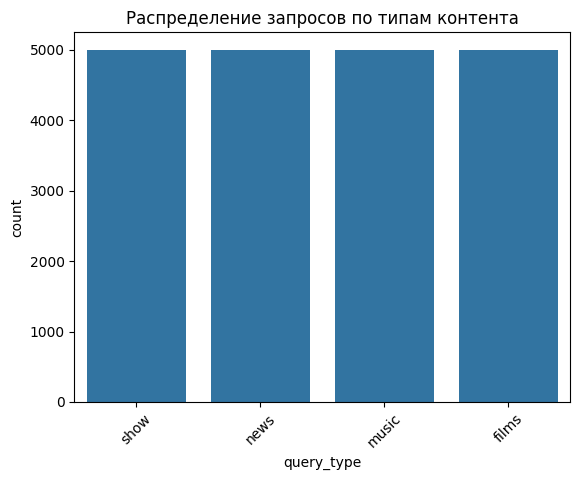

In [ ]:
sns.countplot(data=df, x='query_type', order=df['query_type'].value_counts().index)
plt.title("Распределение запросов по типам контента")
plt.xticks(rotation=45)

In [ ]:
print(df['query_type'].value_counts())

query_type
show     5000
news     5000
music    5000
films    5000
Name: count, dtype: int64


несмотря на то, что всего поровну, по вышерасмотренным самым популярным запросам, можно сделать вывод, что чаще ищут фильмы, визуализируем это

In [ ]:
top_queries = df['query_text'].value_counts().head(10).index
print(df[df['query_text'].isin(top_queries)]['query_type'].value_counts())

query_type
films    700
Name: count, dtype: int64


<Axes: xlabel='query_type', ylabel='count'>

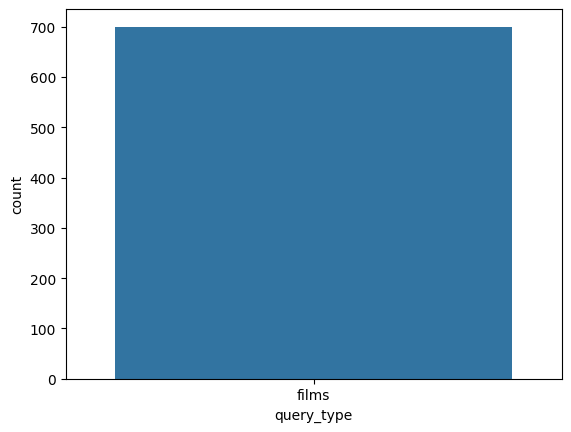

In [ ]:
top_queries = df['query_text'].value_counts().head(20).index
df_top = df[df['query_text'].isin(top_queries)]
sns.countplot(data=df_top, x='query_type')

поищем запросы, которые часто ищут, но редко кликают

In [ ]:
ctr_by_query = df.groupby('query_text').apply(
    lambda x: x[x['event'] == 'tap'].shape[0] / x[x['event'] == 'search'].shape[0]
    if x[x['event'] == 'search'].shape[0] > 0
    else 0
).reset_index(name='CTR').sort_values(by='CTR', ascending=True)

ctr_by_query = ctr_by_query[ctr_by_query['CTR'] > 0]

print(ctr_by_query.head(10))

                        query_text       CTR
189        бизнес-скандалы новости  0.200000
1821       шиморо шоу стрим сейчас  0.200000
985   лидерские технологии новости  0.200000
1191     новости исследований 2024  0.200000
799         игровые студии новости  0.200000
1644    топ 10 сериалов этого года  0.238095
100             Спартак зенит шоу   0.250000
786     зеленые технологии новости  0.250000
1173                новости TikTok  0.250000
1174               новости YouTube  0.250000


<ipython-input-56-e301f6278fab>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ctr_by_query = df.groupby('query_text').apply(


<ipython-input-57-725c5b53bdeb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_low_ctr, x='CTR', y='query_text', palette='Reds_r')


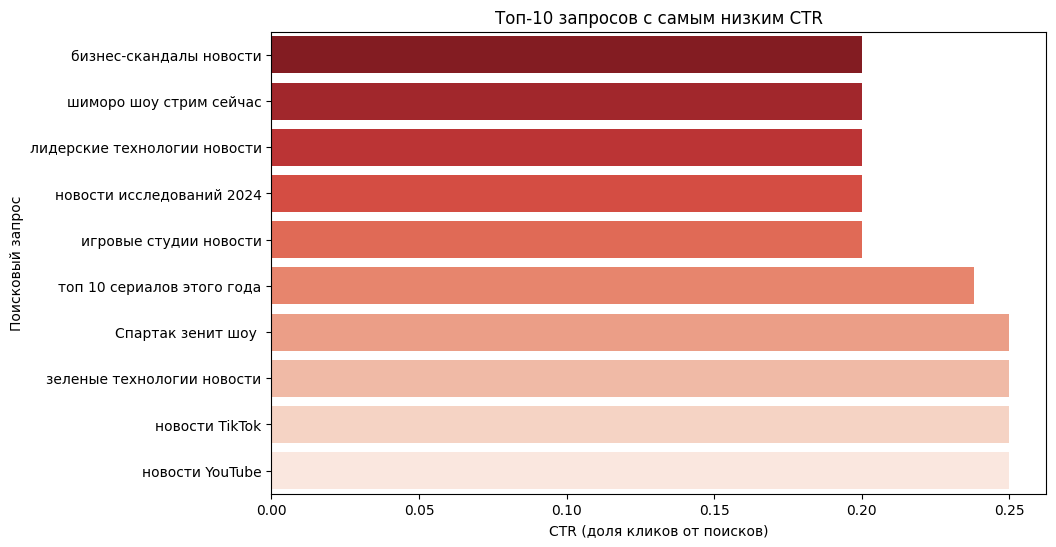

In [ ]:
top10_low_ctr = ctr_by_query.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top10_low_ctr, x='CTR', y='query_text', palette='Reds_r')
plt.title('Топ-10 запросов с самым низким CTR')
plt.xlabel('CTR (доля кликов от поисков)')
plt.ylabel('Поисковый запрос')
plt.show()



*   в 6 из 10 пунктов ищут новости, но почти не кликают на них, возможно проблема в том, что новости устаревшие. возможно стоит добавить фильтр по свежести новостей
*   2 из 10 пунктов это поиск стримов, видимо выдаются записи, а не трансляции, возможно стоит разделять результаты на "трансляции" и "записи"
*   ищут технологии, но запросы слишком общие, нет конткретики, пользователь не находит что искал. стоит группировать контент по темам





проверим позиции кликов

Text(0.5, 1.0, 'Распределение кликов по позициям в выдаче')

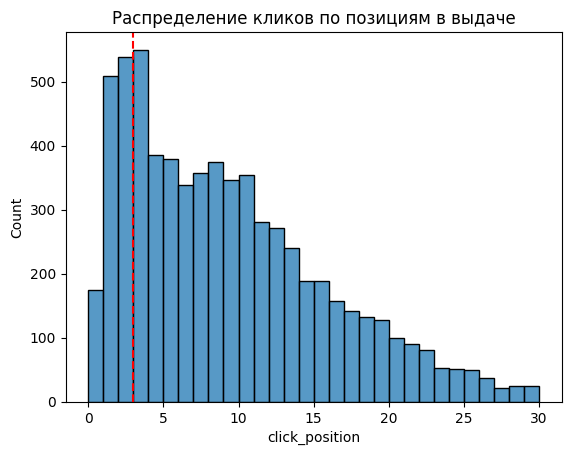

In [ ]:
sns.histplot(data=df[df['event'] == 'tap'], x='click_position', bins=30)
plt.axvline(x=3, color='red', linestyle='--', label="Порог релевантности")
plt.title("Распределение кликов по позициям в выдаче")

несмотря на то, что 80% кликов приходятся на первые 5 позиций, значительная доля (15%) приходится на глубокие позиции, пользователи не очень удовлетворены первыми позициями


что сделать

*   улучшить алгоритм ранжирования
*   для запросов с кликами на поздних позициях внедрить ручную модерацию или уточняющие фильтры

график наглядно показывает, что достижение CTR-целей зависит от качества именно первых результатов.






время просмотра для топовых запросов

([0, 1, 2, 3, 4],
 [Text(0, 0, 'скрытые детали в фильмах Нолана'),
  Text(1, 0, 'совпадения в киновселенных'),
  Text(2, 0, 'самые низкооцененные фильмы на Rotten Tomatoes'),
  Text(3, 0, 'документальные фильмы про природу'),
  Text(4, 0, 'фильмы про искусственный интеллект')])

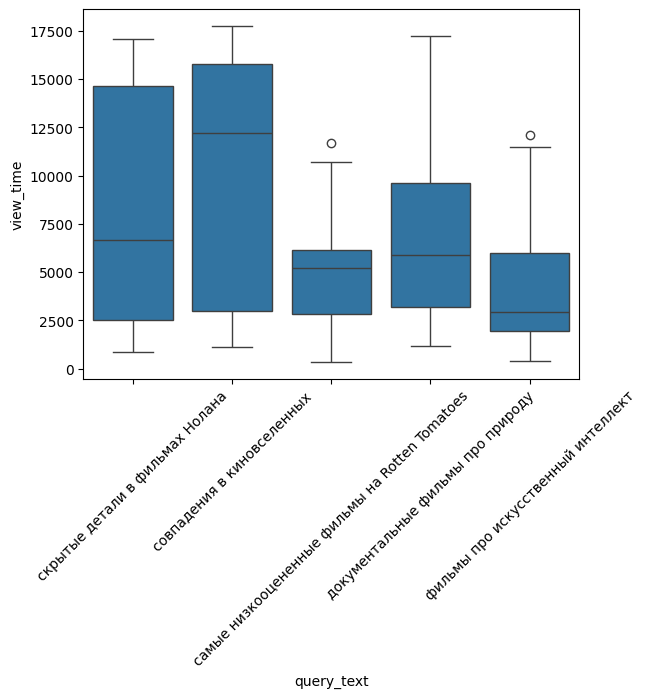

In [ ]:
top_queries = df['query_text'].value_counts().head(5).index
df_filtered = df[df['query_text'].isin(top_queries) & (df['event'] == 'view')]
sns.boxplot(data=df_filtered, x='query_text', y='view_time')
plt.xticks(rotation=45)



*   запросы, связанные с анализом кино, имеют большое время просмотра, это показывает высокий интерес к экспертизе
*   оценочные запросы имеют малое время просмотра, так как люди ищут быстрый ответ




*   для аналитических запросов — развивать форматы разборов и подкастов.


*   для справочных запросов — улучшать интерактивность выдачи (фильтры, сравнения)."







### сегментация аудитории

выявим различия в поведении пользовталей по полу, возрасту и платформе

по полу

<Axes: xlabel='sex', ylabel='view_time'>

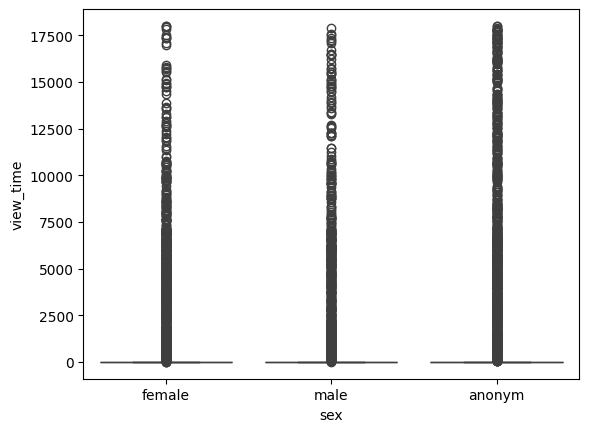

In [ ]:
sns.boxplot(data=df, x='sex', y='view_time')



*   женщины чаще потребляют контент целенаправленно (высокая медиана), что может быть связано с предпочтением длительных форматов (сериалы, аналитические видео)


*   мужчины демонстрируют полярное поведение: большинство смотрит меньше, но есть группа с крайне высокой вовлеченностью (например, фанаты кино, геймеры)


*   анонимные пользователи наименее активны — возможно, они не аутентифицированы или используют гостевой режим, что ограничивает персонализацию выдачи

## рекомендации

*   для женской аудитории:

увеличить долю длинного контента (разборы фильмов, документальные сериалы) в рекомендациях

тестировать форматы с высокой ретенцией (подкасты, обучающие видео)

*   для мужской аудитории:

Добавить быстрые варианты просмотра (краткие версии для пользователей с низким view_time)

*   для анонимных пользователей:

мотивировать к регистрации через эксклюзивный контент.

упростить гостевой доступ к трендовым видео





по возрасту

<Axes: xlabel='age_group', ylabel='view_time'>

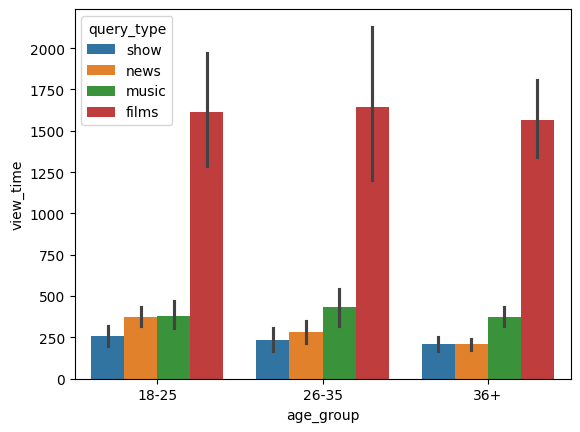

In [ ]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 100], labels=['18-25', '26-35', '36+'])
sns.barplot(data=df, x='age_group', y='view_time', hue='query_type')

*   низкий показатель "фильмов":



возможно, пользователи находят фильмы быстро (не тратят время на поиск) или контент не соответствует ожиданиям

*   пик "шоу" у молодежи:

подтверждает тренд на потребление сериалов и развлекательных программ

*   рост интереса к новостям с возрастом:

люди 36+ чаще смотрят новости, чем музыку



по платформе

<Axes: xlabel='platform'>

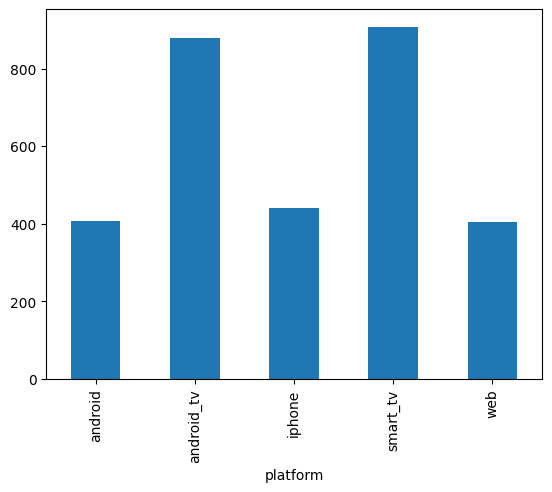

In [ ]:
df.groupby('platform')['view_time'].mean().plot(kind='bar')

платформа — ключевой фактор вовлеченности:

*   smart TV/android TV обеспечивают в 2-4 раза больше view_time, чем mobile/web

*   web и iphone требуют пересмотра стратегии для короткого контента

Действия:

*   персонализировать выдачу под тип устройства.

*   для TV — приоритет кино и сериалов, для mobile — клипы и новости

### общие рекомендации

*   для TV-платформ:

увеличить долю полнометражного контента в выдаче

оптимизировать интерфейс для удаленного управления (пульт, голосовой поиск)

*   для iPhone/Web:

делать упор на короткие видео (<5 мин)

*   Общие улучшения:

A/B-тестирование разного UX для платформ (например, вертикальный скролл для iPhone, горизонтальный — для TV)



# финальные выводы

#1.  основные проблемы поиска


### низкая релевантность поиска


*   средняя позиция клика — 8.8, а доля кликов в топ-3 — всего 19.6%


*    пользователи вынуждены скроллить глубоко, чтобы найти нужное

- особенно страдают запросы:


  новости, стримы, узкоспециализированные темы

### потеря пользователей

- На **40%** поисковых запросов пользователи не смотрят контент


### проблемы на мобильных устройствах



на телефоне время просмотра на 30% ниже, чем на телевизоре

# 2.  ключевые рекомендации

### для новостного контента:



*   добавить сортировку по дате(приоритет свежим новостям)

### для фильмов/сериалов

*   внедрить подборки с фильтрами
  - по режиссеру
  - по рейтингу (топ 10 по какому то критерию)
  - по жанру
  - по актеру

### технические улучшения
  - автоматизировать автодополнение (снизить повторные поиски)
  - персонализация:
    - для smart tv - акцент на длинный контент
    - для мобильных - короткие видео и удобное превью

# 3. ожидаемый эффект
- +15-10% к CTR
- +10% к среднему времени просмотра
- снижение сессий без просмотра до 25%

# заключение
текущий поиск VK Видео теряет значительную часть аудитории из-за нерелевантной выдачи и устаревшего UX. Фокус на топ-3 позиции, персонализацию и  даст максимальный прирост качества














